In [1]:
import numpy as np
import pandas as pd

In [2]:
data = pd.read_excel('/home/growlt259/Desktop/Inventory_Prediction_Retail_Market.xlsx')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Promotion Code,Employee ID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,A,62.0
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,A,46.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,C,13.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,B,22.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,C,79.0


In [3]:
data['sales'] = data['Quantity'] * data['UnitPrice']
data['Date'] = data['InvoiceDate'].dt.date
# data = data[data['Quantity'] > 0]
data.drop(["Promotion Code", "Employee ID"], axis = 1, inplace=True)
data.drop_duplicates(inplace=True)
data.shape

(536643, 10)

In [4]:
desc_to_rmv = ['DOT', 'POST', 'S', 'AMAZONFEE', 'BANK CHARGES', 'CRUK']

In [5]:
data = data[~(data['StockCode'].isin(desc_to_rmv))]
data.shape

(534528, 10)

In [6]:
data = data[~((data['sales'] > 1000) | (data['sales'] < -1000))]

In [7]:
data.set_index('InvoiceDate', inplace=True)
daily_sales = data.sales.resample('D').sum()
daily_sales

InvoiceDate
2010-12-01    54395.50
2010-12-02    41991.32
2010-12-03    42155.90
2010-12-04        0.00
2010-12-05    30559.63
                ...   
2011-12-05    80014.34
2011-12-06    51416.62
2011-12-07    55000.65
2011-12-08    66851.77
2011-12-09    29305.57
Freq: D, Name: sales, Length: 374, dtype: float64

<Axes: xlabel='InvoiceDate'>

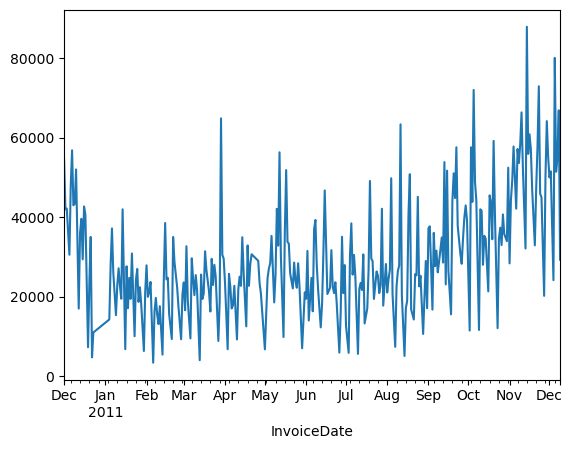

In [8]:
daily_sales.replace(0, np.nan, inplace=True)
daily_sales.interpolate(method = 'linear', inplace=True)
daily_sales.plot()

In [9]:
daily_sales = pd.DataFrame(daily_sales)
daily_sales.head()

,sales
InvoiceDate,
2010-12-01,54395.500
2010-12-02,41991.320
2010-12-03,42155.900
2010-12-04,36357.765
2010-12-05,30559.630


In [10]:
def create_lagged_features(data, lags):
    df_lagged = pd.DataFrame(index=data.index)
    df_lagged['y'] = data.values
    for lag in range(1, lags + 1):
        df_lagged[f'lag_{lag}'] = data.shift(lag)
    df_lagged.dropna(inplace=True)
    return df_lagged

lags = 7
df_lagged = create_lagged_features(daily_sales['sales'], lags)

In [11]:
# Step 2: Extract day of the week and one-hot encode
daily_sales['day_of_week'] = daily_sales.index.day_name()
daily_sales_encoded = pd.get_dummies(daily_sales['day_of_week'], prefix='is').astype(int)

# Combine the original dataframe with the one-hot encoded columns
df = pd.concat([daily_sales, daily_sales_encoded], axis=1)

# Step 3: Add one-hot encoded columns to lagged features dataframe
# We need to shift the day of the week columns as well
df_features = df.drop('sales', axis=1)
df_features = df_features.shift(lags).dropna()

# Concatenate the lagged features with the shifted one-hot encoded columns
df_combined = pd.concat([df_lagged, df_features], axis=1)

# Drop any remaining NaN values
df_combined.drop('day_of_week', axis = 1, inplace=True)
df_combined.dropna(inplace=True)

# Check the resulting dataframe
print(df_combined.head())

                    y     lag_1     lag_2     lag_3      lag_4      lag_5  \
InvoiceDate                                                                 
2010-12-08   42993.80  56801.23  47903.48  30559.63  36357.765  42155.900   
2010-12-09   43344.83  42993.80  56801.23  47903.48  30559.630  36357.765   
2010-12-10   51991.72  43344.83  42993.80  56801.23  47903.480  30559.630   
2010-12-11   34514.61  51991.72  43344.83  42993.80  56801.230  47903.480   
2010-12-12   17037.50  34514.61  51991.72  43344.83  42993.800  56801.230   

                 lag_6      lag_7  is_Friday  is_Monday  is_Saturday  \
InvoiceDate                                                            
2010-12-08   41991.320  54395.500        0.0        0.0          0.0   
2010-12-09   42155.900  41991.320        0.0        0.0          0.0   
2010-12-10   36357.765  42155.900        1.0        0.0          0.0   
2010-12-11   30559.630  36357.765        0.0        0.0          1.0   
2010-12-12   47903.480  3055

In [12]:
train_size = 344
train, test = df_combined.iloc[:train_size], df_combined.iloc[train_size:]

X_train, y_train = train.drop('y', axis=1), train['y']
X_test, y_test = test.drop('y', axis=1), test['y']

In [19]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
# Define the model
model = XGBRegressor(objective='reg:squarederror', n_estimators = 100)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Mean Absolute Error: 8816.649181385868


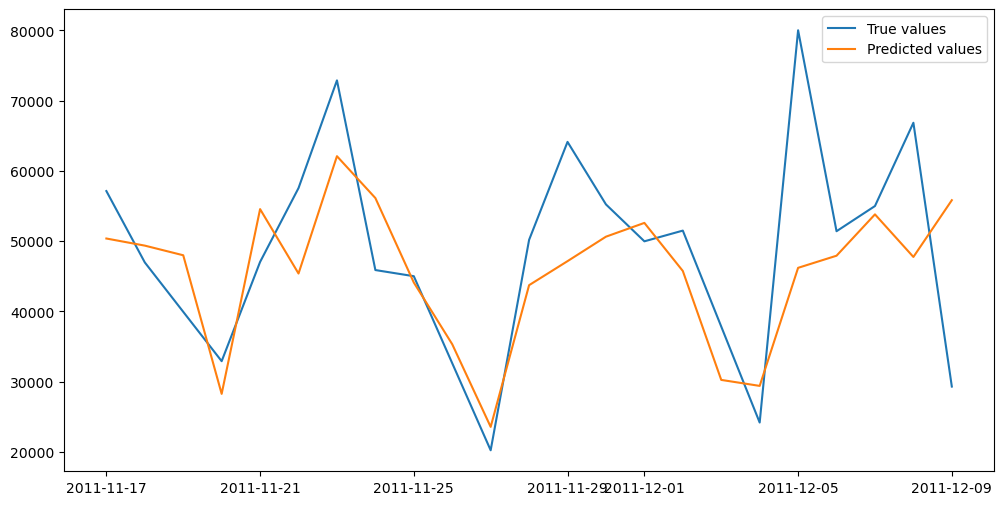

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

y_pred = model.predict(X_test)

# Calculate Mean Squared Error
mse = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mse}')

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='True values')
plt.plot(test.index, y_pred, label='Predicted values')
plt.legend()
plt.show()

In [21]:
from sklearn.metrics import r2_score
print(r2_score(y_test, y_pred))

0.3297142853306796


In [22]:
print(mean_absolute_error(y_test, y_pred))

8816.649181385868


In [18]:
y_test.mean()

48429.80086956522

In [38]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [39]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=42)

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/growlt259/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
396 fits failed with the following error:
Traceback (most recent call last):
  File "/home/growlt259/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/growlt259/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/home/growlt259/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 637, in _validate_params
    validate_parameter_constraints(

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_absolute_error', verbose=1)

Best parameters found:  {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation score (neg_mean_absolute_error):  -7531.197441891633


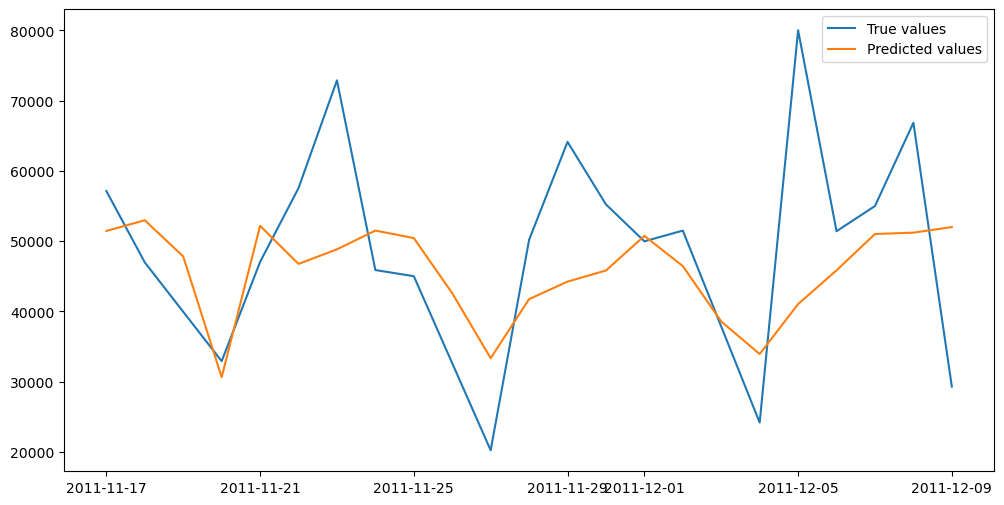

In [40]:
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score (neg_mean_absolute_error): ", grid_search.best_score_)

# Predict using the best estimator
best_model = grid_search.best_estimator_
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Evaluate the model
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='True values')
plt.plot(test.index, y_pred_test, label='Predicted values')
plt.legend()
plt.show()

In [41]:
print(r2_score(y_test, y_pred_test))

0.14444083661920493


In [42]:
X = df_combined.drop(columns='y')

feature_importances = pd.DataFrame(best_model.feature_importances_, index=X.columns, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

              importance
lag_7           0.193310
lag_1           0.174917
lag_6           0.130847
lag_2           0.106939
lag_4           0.094193
lag_5           0.088632
lag_3           0.080650
is_Sunday       0.058059
is_Thursday     0.021112
is_Saturday     0.015506
is_Tuesday      0.015016
is_Monday       0.008993
is_Wednesday    0.006770
is_Friday       0.005056


In [43]:
print(train_mae, test_mae)

2560.054796506643 10295.715332463771
